# Import Libraries

In [ ]:
import nltk
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dataset

In [ ]:
smoking_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/smoking dataset.csv')
smoking_df.head()

,ID,STATUS,TEXT
0,641,CURRENT SMOKER,977146916\nHLGMC\n2878891\n022690\n01/27/1997 ...
1,643,CURRENT SMOKER,026738007\nCMC\n15319689\n3/25/1998 12:00:00 A...
2,681,CURRENT SMOKER,071962960\nBH\n4236518\n417454\n12/10/2001 12:...
3,704,CURRENT SMOKER,418520250\nNVH\n61562872\n3/11/1995 12:00:00 A...
4,757,CURRENT SMOKER,301443520\nCTMC\n49020928\n448922\n1/11/1990 1...


In [ ]:
smoking_df.info()
print('Number of Medical Records: ',len(smoking_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      398 non-null    int64 
 1   STATUS  398 non-null    object
 2   TEXT    398 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB
Number of Medical Records:  398


# To check the distribution and types of categories

Label types and counts: 
 ['CURRENT SMOKER' 'NON-SMOKER' 'PAST SMOKER' 'SMOKER' 'UNKNOWN'] 
 [35, 66, 36, 9, 252]


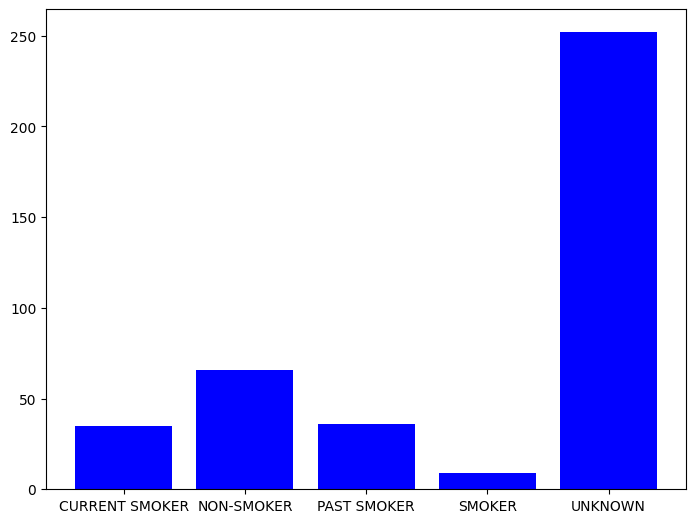

In [ ]:
label_types=smoking_df['STATUS'].unique()

counts=[]
for i in label_types:
  count=len(smoking_df[smoking_df.STATUS==i])
  counts.append(count)
print('Label types and counts:','\n',label_types,'\n',counts)

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
plt.bar(label_types,counts,color='b')
plt.show()


Here, we can see that classes are not distributed equally

# Data Preprocessing

Checking and Removing rows with null values

In [ ]:
# Check rows with null values
smoking_df.isnull().sum().sort_values(ascending=False)

ID        0
STATUS    0
TEXT      0
dtype: int64

In [ ]:
#Remove rows with nulls
smoking_df=smoking_df[smoking_df['TEXT'].notna()]
smoking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      398 non-null    int64 
 1   STATUS  398 non-null    object
 2   TEXT    398 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


Drop Duplicates

In [ ]:
smoking_df['ID'].drop_duplicates()

0      641
1      643
2      681
3      704
4      757
      ... 
393    401
394    403
395    416
396    417
397    419
Name: ID, Length: 398, dtype: int64

Lower casing of Text

In [ ]:
smoking_df['CLEAN_TEXT']=smoking_df['TEXT'].str.lower()
smoking_df.head()

,ID,STATUS,TEXT,CLEAN_TEXT
0,641,CURRENT SMOKER,977146916\nHLGMC\n2878891\n022690\n01/27/1997 ...,977146916\nhlgmc\n2878891\n022690\n01/27/1997 ...
1,643,CURRENT SMOKER,026738007\nCMC\n15319689\n3/25/1998 12:00:00 A...,026738007\ncmc\n15319689\n3/25/1998 12:00:00 a...
2,681,CURRENT SMOKER,071962960\nBH\n4236518\n417454\n12/10/2001 12:...,071962960\nbh\n4236518\n417454\n12/10/2001 12:...
3,704,CURRENT SMOKER,418520250\nNVH\n61562872\n3/11/1995 12:00:00 A...,418520250\nnvh\n61562872\n3/11/1995 12:00:00 a...
4,757,CURRENT SMOKER,301443520\nCTMC\n49020928\n448922\n1/11/1990 1...,301443520\nctmc\n49020928\n448922\n1/11/1990 1...


Removal of Punctuations

In [ ]:
print('Punctuations:  ',string.punctuation)
def remove_punctuations(text):
  punctuation=string.punctuation
  return text.translate(str.maketrans('','',punctuation))

smoking_df['CLEAN_TEXT']=smoking_df['CLEAN_TEXT'].apply(lambda x:remove_punctuations(x))
smoking_df.head()

Punctuations:   !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,ID,STATUS,TEXT,CLEAN_TEXT
0,641,CURRENT SMOKER,977146916\nHLGMC\n2878891\n022690\n01/27/1997 ...,977146916\nhlgmc\n2878891\n022690\n01271997 12...
1,643,CURRENT SMOKER,026738007\nCMC\n15319689\n3/25/1998 12:00:00 A...,026738007\ncmc\n15319689\n3251998 120000 am\nm...
2,681,CURRENT SMOKER,071962960\nBH\n4236518\n417454\n12/10/2001 12:...,071962960\nbh\n4236518\n417454\n12102001 12000...
3,704,CURRENT SMOKER,418520250\nNVH\n61562872\n3/11/1995 12:00:00 A...,418520250\nnvh\n61562872\n3111995 120000 am\nd...
4,757,CURRENT SMOKER,301443520\nCTMC\n49020928\n448922\n1/11/1990 1...,301443520\nctmc\n49020928\n448922\n1111990 120...


Removal of Special Characters

In [ ]:
import re
def remove_splchars(text):
  text=re.sub('[^A-Za-z0-9]',' ',text)
  text=re.sub('\s+',' ',text)
  return text

smoking_df['CLEAN_TEXT']=smoking_df['CLEAN_TEXT'].apply(lambda x:remove_splchars(x))
smoking_df.head()



,ID,STATUS,TEXT,CLEAN_TEXT
0,641,CURRENT SMOKER,977146916\nHLGMC\n2878891\n022690\n01/27/1997 ...,977146916 hlgmc 2878891 022690 01271997 120000...
1,643,CURRENT SMOKER,026738007\nCMC\n15319689\n3/25/1998 12:00:00 A...,026738007 cmc 15319689 3251998 120000 am media...
2,681,CURRENT SMOKER,071962960\nBH\n4236518\n417454\n12/10/2001 12:...,071962960 bh 4236518 417454 12102001 120000 am...
3,704,CURRENT SMOKER,418520250\nNVH\n61562872\n3/11/1995 12:00:00 A...,418520250 nvh 61562872 3111995 120000 am disch...
4,757,CURRENT SMOKER,301443520\nCTMC\n49020928\n448922\n1/11/1990 1...,301443520 ctmc 49020928 448922 1111990 120000 ...


Removal of Stop words

In [ ]:
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')
print('Stop words:',stopwords)

def remove_stopwords(text):
  return" ".join(word for word in text.split() if word not in stopwords)

smoking_df['CLEAN_TEXT']=smoking_df['CLEAN_TEXT'].apply(lambda x:remove_stopwords(x))
smoking_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

,ID,STATUS,TEXT,CLEAN_TEXT
0,641,CURRENT SMOKER,977146916\nHLGMC\n2878891\n022690\n01/27/1997 ...,977146916 hlgmc 2878891 022690 01271997 120000...
1,643,CURRENT SMOKER,026738007\nCMC\n15319689\n3/25/1998 12:00:00 A...,026738007 cmc 15319689 3251998 120000 mediasti...
2,681,CURRENT SMOKER,071962960\nBH\n4236518\n417454\n12/10/2001 12:...,071962960 bh 4236518 417454 12102001 120000 di...
3,704,CURRENT SMOKER,418520250\nNVH\n61562872\n3/11/1995 12:00:00 A...,418520250 nvh 61562872 3111995 120000 discharg...
4,757,CURRENT SMOKER,301443520\nCTMC\n49020928\n448922\n1/11/1990 1...,301443520 ctmc 49020928 448922 1111990 120000 ...


Checking for most Frequent and Rare words

In [ ]:
# Checking for the most frequent words
from collections import Counter
word_count=Counter()
for text in smoking_df['CLEAN_TEXT']:
  for word in text.split():
    word_count[word]+=1

word_count.most_common(10)

[('patient', 3387),
 ('discharge', 1795),
 ('mg', 1530),
 ('po', 1490),
 ('history', 1339),
 ('admission', 1056),
 ('left', 1030),
 ('right', 989),
 ('hospital', 909),
 ('md', 888)]

In [ ]:
# Checking for Rare words
rare_words=set(word for(word,wc)in word_count.most_common()[-10:-1])
print(rare_words)

{'plt150', 'pancx', 'jt0', 'contribute', 'elederly', 'wbc78', 'k44', 'safe', 'glu92'}


Removing frequent and rare words from medical text may lead to loss of valuable clinical information and hinder accurate analysis.
Hence, I decided not to remove the frequent and rare words.

Lemmatization and POS tagging

In [ ]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer=WordNetLemmatizer()
wordnet_map={'N':wordnet.NOUN,'V':wordnet.VERB,'J':wordnet.ADJ,'R':wordnet.ADV}

def lemmatize_words(text):
  # find pos tags
  pos_text=pos_tag(text.split())
  return' '.join([lemmatizer.lemmatize(word,wordnet_map.get(pos[0],wordnet.NOUN)) for word,pos in pos_text])

smoking_df['CLEAN_TEXT']=smoking_df['CLEAN_TEXT'].apply(lambda x:lemmatize_words(x))
smoking_df.head()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,ID,STATUS,TEXT,CLEAN_TEXT
0,641,CURRENT SMOKER,977146916\nHLGMC\n2878891\n022690\n01/27/1997 ...,977146916 hlgmc 2878891 022690 01271997 120000...
1,643,CURRENT SMOKER,026738007\nCMC\n15319689\n3/25/1998 12:00:00 A...,026738007 cmc 15319689 3251998 120000 mediasti...
2,681,CURRENT SMOKER,071962960\nBH\n4236518\n417454\n12/10/2001 12:...,071962960 bh 4236518 417454 12102001 120000 di...
3,704,CURRENT SMOKER,418520250\nNVH\n61562872\n3/11/1995 12:00:00 A...,418520250 nvh 61562872 3111995 120000 discharg...
4,757,CURRENT SMOKER,301443520\nCTMC\n49020928\n448922\n1/11/1990 1...,301443520 ctmc 49020928 448922 1111990 120000 ...


In [ ]:
clean_text=smoking_df['CLEAN_TEXT']
text=smoking_df['TEXT']
labels=smoking_df['STATUS']
cleaneddata_labels=list(zip(clean_text,labels))
data_labels=list(zip(text,labels))
print('Raw data: ',data_labels[0])
print('Cleaned data: ',cleaneddata_labels[0])

Raw data:  ("977146916\nHLGMC\n2878891\n022690\n01/27/1997 12:00:00 AM\nCARCINOMA OF THE COLON .\nUnsigned\nDIS\nReport Status :\nUnsigned\nPlease do not go above this box important format codes are contained .\nDISCHARGE SUMMARY\nARF32 FA\nDISCHARGE SUMMARY NAME :\nGIRRESNET , DIEDREO A\nUNIT NUMBER :\n075-71-01\nADMISSION DATE :\n01/27/1997\nDISCHARGE DATE :\n01/31/1997\nPRINCIPAL DIAGNOSIS :\nCarcinoma of the colon .\nASSOCIATED DIAGNOSIS :\nUrinary tract infection , and cirrhosis of the liver .\nHISTORY OF PRESENT ILLNESS :\nThe patient is an 80-year-old male , who had a history of colon cancer in the past , resected approximately ten years prior to admission , history of heavy alcohol use , who presented with a two week history of poor PO intake , weight loss , and was noted to have acute on chronic Hepatitis by chemistries and question of pyelonephritis .\nHe lived alone but was driven to the hospital by his son because of reported worsening and general care and deconditioning .\

# Naive Bayes Classifier

# Split the Cleaned Dataset into Train and Test

In [ ]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(cleaneddata_labels,test_size=0.2,random_state=7)
print('Number of training medical records: ',len(train_set))
print('train_set[0]: ',train_set[0])
print('Number of testing medical records: ',len(test_set))
print('test_set[0]: ',test_set[0])

Number of training medical records:  318
train_set[0]:  ('420033129 yc 87142319 129591 12121996 120000 discharge summary sign dis admission date 12121996 report status sign discharge date 12161996 principal diagnosis status post total abdominal hysterectomy bilateral salpingooophorectomy associate diagnosis 1 menorrhagia 2 pelvic pain 3 endometriosis principal procedure tahbso history reason hospitalization patient 42 year old gravida ii para female long history menorrhagia pelvic pain also history endometriosis symptomatic use danocrine approximately nine month pain free unable tolerate side effect status post several laparoscopy past diagnosed endometriosis recently depoprovera episode breakthrough bleed six week time desired surgical therapy hospital course 121296 uncomplicated total abdominal hysterectomy bilateral salpingooophorectomy estimate blood loss 100 cc tolerate procedure well postop day number one afebrile well pca pain control postop day number two also afebrile pass fla

# Building Unigram Feature Sets

In [ ]:
nltk.download('punkt')
def unigram_features(data)->[(dict,str)]:
  smo_ctexts=[d[0] for d in data]
  smo_labels=[d[1] for d in data]
  feature_dicts=[{word: True for word in nltk.word_tokenize(str(smo_ctext))} for smo_ctext in smo_ctexts ]
  return list(zip(feature_dicts,smo_labels))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Train the Model

In [ ]:
debug_feature_sets=unigram_features(train_set)
classifier=nltk.NaiveBayesClassifier.train(debug_feature_sets)

# Prediction and Evaluation

In [ ]:
# Prediction
test_feature_sets=unigram_features(test_set)
test_dict=test_feature_sets[0][0]
print('Real value: ',test_feature_sets[0][1])
prediction=classifier.classify(test_dict)
print('Predicted value: ',prediction)

# Evaluation
def evaluate_classifier(classifier,test_data)->float:
  test_feature_sets=unigram_features(test_data)
  return nltk.classify.accuracy(classifier,test_feature_sets)
acc=evaluate_classifier(classifier,test_set)
print('Accuracy of unigram: ',acc)

Real value:  UNKNOWN
Predicted value:  PAST SMOKER
Accuracy of unigram:  0.2


In [ ]:
num_test_lables=len(test_set)
print('num_test_labels: ',num_test_lables)

true_labels=[]
for i in range(num_test_lables):
  true_labels.append(test_feature_sets[i][1])
print('True labels: ',true_labels)

predicted_labels=[]
for i in range(num_test_lables):
  prediction=classifier.classify(test_feature_sets[i][0])
  predicted_labels.append(prediction)
print('predicted labels', predicted_labels)

print(classification_report(true_labels, predicted_labels))

num_test_labels:  80
True labels:  ['UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'NON-SMOKER', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'NON-SMOKER', 'NON-SMOKER', 'CURRENT SMOKER', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'U

# Building Bigram Feature Sets

In [ ]:
def bigram_features(data)->[(dict,str)]:
  smo_ctexts=[d[0] for d in data]
  smo_labels=[d[1] for d in data]
  feature_dicts=[{word: True for word in nltk.bigrams(nltk.word_tokenize(str(smo_ctext)))} for smo_ctext in smo_ctexts ]
  return list(zip(feature_dicts,smo_labels))

# Train the Model

In [ ]:
bigram_feature_sets=bigram_features(train_set)
bigram_classifier=nltk.NaiveBayesClassifier.train(bigram_feature_sets)

# Prediction and Evaluation

In [ ]:
# Prediction
test_feature_sets=bigram_features(test_set)
test_dict=test_feature_sets[1][0]
print('Real value: ',test_feature_sets[1][1])
prediction=bigram_classifier.classify(test_dict)
print('Predicted value: ',prediction)

# Evaluation
def evaluate_bigram_classifier(classifier,test_data)->float:
  test_feature_sets=bigram_features(test_data)
  return nltk.classify.accuracy(classifier,test_feature_sets)

acc_bigram=evaluate_bigram_classifier(classifier,test_set)
print('Accuracy of Bigram: ',acc_bigram)

Real value:  UNKNOWN
Predicted value:  UNKNOWN
Accuracy of Bigram:  0.65


In [ ]:
num_test_lables=len(test_set)
print('num_test_labels: ',num_test_lables)

true_labels=[]
for i in range(num_test_lables):
  true_labels.append(test_feature_sets[i][1])
print('True labels: ',true_labels)

predicted_labels=[]
for i in range(num_test_lables):
  prediction=bigram_classifier.classify(test_feature_sets[i][0])
  predicted_labels.append(prediction)
print('predicted labels', predicted_labels)

print(classification_report(true_labels, predicted_labels))

num_test_labels:  80
True labels:  ['UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'NON-SMOKER', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'NON-SMOKER', 'NON-SMOKER', 'CURRENT SMOKER', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'U

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Building Trigram Feature Sets

In [ ]:
def trigram_features(data)->[(dict,str)]:
  smo_ctexts=[d[0] for d in data]
  smo_labels=[d[1] for d in data]
  feature_dicts=[{word: True for word in nltk.trigrams(nltk.word_tokenize(str(smo_ctext)))} for smo_ctext in smo_ctexts ]
  return list(zip(feature_dicts,smo_labels))

# Train the Model

In [ ]:
trigram_feature_sets=trigram_features(train_set)
trigram_classifier=nltk.NaiveBayesClassifier.train(trigram_feature_sets)

# Prediction and Evaluation

In [ ]:
# Prediction
test_feature_sets=trigram_features(test_set)
test_dict=test_feature_sets[1][0]
print('Real value: ',test_feature_sets[1][1])
prediction=trigram_classifier.classify(test_dict)
print('Predicted value: ',prediction)

# Evaluation
def evaluate_trigram_classifier(classifier,test_data)->float:
  test_feature_sets=trigram_features(test_data)
  return nltk.classify.accuracy(classifier,test_feature_sets)

acc_trigram=evaluate_trigram_classifier(classifier,test_set)
print('Accuracy of Trigram: ',acc_trigram)

Real value:  UNKNOWN
Predicted value:  SMOKER
Accuracy of Trigram:  0.65


In [ ]:
num_test_lables=len(test_set)
print('num_test_labels: ',num_test_lables)

true_labels=[]
for i in range(num_test_lables):
  true_labels.append(test_feature_sets[i][1])
print('True labels: ',true_labels)

predicted_labels=[]
for i in range(num_test_lables):
  prediction=trigram_classifier.classify(test_feature_sets[i][0])
  predicted_labels.append(prediction)
print('predicted labels', predicted_labels)

print(classification_report(true_labels, predicted_labels))

num_test_labels:  80
True labels:  ['UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'NON-SMOKER', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'NON-SMOKER', 'NON-SMOKER', 'CURRENT SMOKER', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'U

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion matrix

num_test_labels:  80
True labels:  ['UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'NON-SMOKER', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'CURRENT SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'CURRENT SMOKER', 'NON-SMOKER', 'NON-SMOKER', 'CURRENT SMOKER', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'CURRENT SMOKER', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'UNKNOWN', 'NON-SMOKER', 'UNKNOWN', 'PAST SMOKER', 'UNKNOWN', 'U

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


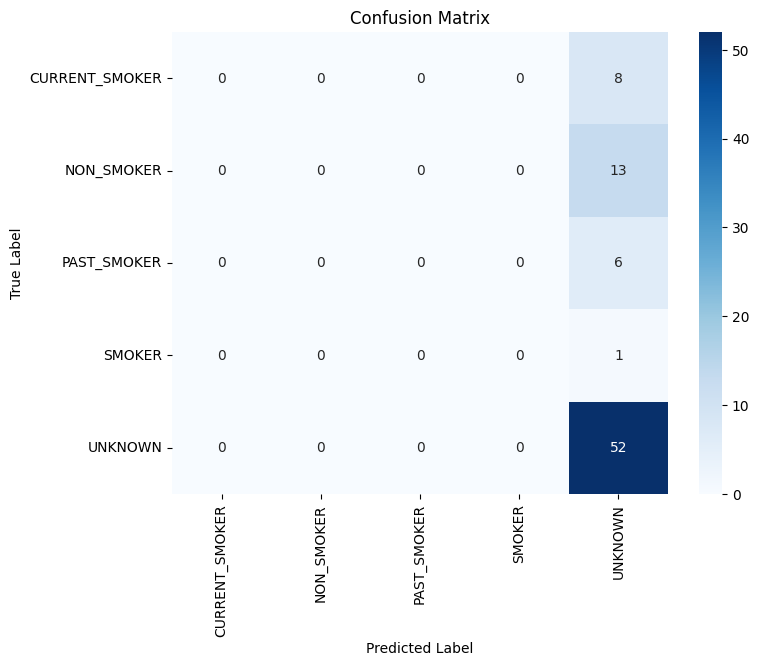

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

num_test_lables=len(test_set)
print('num_test_labels: ',num_test_lables)

true_labels=[]
for i in range(num_test_lables):
  true_labels.append(test_feature_sets[i][1])
print('True labels: ',true_labels)

predicted_labels=[]
for i in range(num_test_lables):
  prediction=classifier.classify(test_feature_sets[i][0])
  predicted_labels.append(prediction)
print('predicted labels', predicted_labels)

print('Report of NB classifier with unigrams\n',classification_report(true_labels, predicted_labels))

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
class_labels = ["CURRENT_SMOKER","NON_SMOKER","PAST_SMOKER","SMOKER","UNKNOWN"]
# Plot confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()